Import Library

In [2]:
# A specific version of opencv was used for dnn upscalling, please uninstall any current versions 
# and use the following command for the installation "pip install --upgrade opencv-contrib-python"
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from cv2 import dnn_superres
from moviepy.editor import *
from moviepy.audio.fx.all import audio_fadeout, audio_fadein
from PIL import ImageDraw, ImageFilter, Image, ImageEnhance, ImageColor, ImageOps
from IPython.display import Video
from rembg import remove
from tqdm import tqdm

General Function

In [8]:
# Scales the inputimage by scale_factor
def scale_image(image, scale_factor):
    width, height = image.size
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    return image.resize((new_width, new_height))

# Removes background from the input image
def remove_background(image):
    new_image = remove(image)
    return new_image

# Adjusts brightness of the input image by the specified factor
def adjust_brightness(image, factor):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

# Adjust the opacity of the input image by the specified factor
def crop_and_adjust_opacity(image, opacity_factor):
    # Crop to visible content
    alpha = image.split()[-1]
    bbox = alpha.getbbox()
    cropped = image.crop(bbox)
    
    # Adjust opacity
    pixels = cropped.load()
    width, height = cropped.size
    for x in range(width):
        for y in range(height):
            r, g, b, a = pixels[x, y]
            pixels[x, y] = (r, g, b, int(a * opacity_factor))
    
    return cropped

# Adjusts blur of the input image by the specified radius
def blur_image(image, radius=2):
    return image.filter(ImageFilter.GaussianBlur(radius))

# Pastes the overlay image onto the background image with rotation
def paste_with_rotation(background, overlay, x_factor, y_factor, rotation_degrees):
    rotated_overlay = overlay.rotate(rotation_degrees, expand=True)
    bg_width, bg_height = background.size
    offset_x = int(bg_width * x_factor)
    offset_y = int(bg_height * y_factor)
    paste_x = offset_x - rotated_overlay.width // 2
    paste_y = offset_y - rotated_overlay.height // 2
    background.paste(rotated_overlay, (paste_x, paste_y), rotated_overlay)

# Creates a shadow effect for the input image
def create_shadow(image, blur_radius=10, opacity=0.5, squash_factor=0.5, squash_axis="y"):
    shadow = Image.new("RGBA", image.size, (0, 0, 0, 0))
    for x in range(image.width):
        for y in range(image.height):
            _, _, _, a = image.getpixel((x, y))
            if a > 0:
                shadow.putpixel((x, y), (0, 0, 0, int(255 * opacity)))

    shadow = shadow.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    if squash_axis.lower() == "x":
        new_width = int(shadow.width * squash_factor)
        shadow = shadow.resize((new_width, shadow.height), Image.LANCZOS)
    elif squash_axis.lower() == "y":
        new_height = int(shadow.height * squash_factor)
        shadow = shadow.resize((shadow.width, new_height), Image.LANCZOS)
    else:
        raise ValueError("squash_axis must be either x or y")

    return shadow

# Adds a vignette effect to the input image with the specified strength
def add_vignette(image, strength=0.75):
    width, height = image.size
    mask = Image.new("L", (width, height))
    draw = ImageDraw.Draw(mask)
    
    for y in range(height):
        for x in range(width):
            distance = min(1.0, ((x - width/2.0)**2 + (y - height/2.0)**2) / ((width/2.0)**2 + (height/2.0)**2))
            darkness = int(255 * (1 - distance * strength))
            draw.point((x, y), fill=darkness)
    
    return Image.composite(image, Image.new("RGB", (width, height), "black"), mask)

def create_pisa_animation(image, fps, num_frames, min_factor=0.85, max_factor=1.2, amplitude=6.5, frequency=144, shake_start=0.25, shake_end=0.75, shake_amplitude=5):
    image.thumbnail((3264, 2448), Image.LANCZOS)
    width, height = image.size
    pixels = image.load()
    frames = []

    for i in tqdm(range(num_frames), desc="Creating animation frames", unit="frame"):
        new_image = Image.new("RGBA", (3264, 2448), (0, 0, 0, 0))
        new_pixels = new_image.load()
        phase_shift = i / num_frames
        
        # Apply shaking effect if within the specified time range
        shake_offset_x = 0
        shake_offset_y = 0
        if shake_start <= phase_shift < shake_end:
            shake_offset_x = int(shake_amplitude * (np.random.random() - 0.5) * 2)  # Random shake in x direction
            shake_offset_y = int(shake_amplitude * (np.random.random() - 0.5) * 2)  # Random shake in y direction

        for x in range(width):
            for y in range(height):
                offset = int(amplitude * np.sin(2 * np.pi * (x / frequency + phase_shift)))
                new_x = x + shake_offset_x
                new_y = y + offset + shake_offset_y
                if 0 <= new_x < width and 0 <= new_y < height:
                    new_pixels[new_x, new_y] = pixels[x, y]

        factor = min_factor + (max_factor - min_factor) * abs(np.sin(2 * np.pi * i / num_frames))
        enhancer = ImageEnhance.Brightness(new_image)
        bright_wave_frame = enhancer.enhance(factor)

        zoom_factor = 1.1
        zoomed_width = int(width * zoom_factor)
        zoomed_height = int(height * zoom_factor)
        zoomed_bright_wave_frame = bright_wave_frame.resize((zoomed_width, zoomed_height), Image.LANCZOS)

        canvas = Image.new("RGBA", (3264, 2448), (0, 0, 0, 0))
        canvas.paste(zoomed_bright_wave_frame, ((3264 - zoomed_width) // 2, (2448 - zoomed_height) // 2))

        frames.append(canvas)

    return frames

def images_to_video(image_folder, video_file, fps=24):
    images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]

    if not images:
        raise ValueError("No PNG images found in the directory.")

    first_frame = cv2.imread(os.path.join(image_folder, images[0]))
    if first_frame is None:
        raise ValueError(f"Unable to read the image file {images[0]}")
    height, width, layers = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_file, fourcc, fps, (width, height))

    for image in tqdm(images, desc="Creating video", unit = "frame"):
        frame = cv2.imread(os.path.join(image_folder, image))
        if frame is None:
            print(f"Warning: Unable to read the image file {image}. Skipping...")
            continue
        if frame.shape[0] != height or frame.shape[1] != width:
            print(f"Warning: The image file {image} has different dimensions. Resizing...")
            frame = cv2.resize(frame, (width, height))
        video.write(frame)

    video.release()
    print(f"Video saved as {video_file}")

def add_audio_to_video(video_path, audio_path, output_path, fade_duration=3, audio_start_frac=0, audio_end_frac=1):
    video = VideoFileClip(video_path)
    background_music = AudioFileClip(audio_path)

    audio_start = video.duration * audio_start_frac
    audio_end = video.duration * audio_end_frac

    if audio_end > video.duration:
        audio_end = video.duration
    
    audio_duration = audio_end - audio_start
    background_music = background_music.subclip(0, min(audio_duration, background_music.duration))

    background_music = audio_fadein(background_music, duration=fade_duration)
    background_music = audio_fadeout(background_music, duration=fade_duration)
    background_music = background_music.volumex(0.8)

    if video.audio is None:
        final_audio = background_music.set_start(audio_start)
    else:
        background_music = background_music.set_start(audio_start)
        final_audio = CompositeAudioClip([video.audio, background_music])

    final_video = video.set_audio(final_audio)
    final_video.write_videofile(output_path, codec="libx264", audio_codec="aac")

    video.close()
    background_music.close()
    final_video.close()
    
def apply_sobel(image):
    rgba_channels = cv2.split(image)
    rgb_image = cv2.merge(rgba_channels[:3])
    alpha_channel = rgba_channels[3]

    rgb_gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    sobel_x = cv2.Sobel(rgb_gray, cv2.CV_64F, 1, 0, ksize=1)
    sobel_y = cv2.Sobel(rgb_gray, cv2.CV_64F, 0, 1, ksize=1)
    sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)
    sobel_magnitude = cv2.convertScaleAbs(sobel_magnitude)

    sobel_rgba = cv2.merge([sobel_magnitude, sobel_magnitude, sobel_magnitude, alpha_channel])

    return sobel_rgba

def apply_perspective_transform(image, top_shrink=0.5, bottom_expand=1.2):
    original_points = np.float32([[0, 0], [image.shape[1], 0],
                                  [image.shape[1], image.shape[0]],
                                  [0, image.shape[0]]])

    desired_points = np.float32([[int(image.shape[1] * (1 - top_shrink) / 2), int(image.shape[0] * top_shrink)],
                                 [int(image.shape[1] * (1 + top_shrink) / 2), int(image.shape[0] * top_shrink)],
                                 [int(image.shape[1] * (1 + bottom_expand) / 2), int(image.shape[0] * bottom_expand)],
                                 [int(image.shape[1] * (1 - bottom_expand) / 2), int(image.shape[0] * bottom_expand)]])

    perspective_matrix = cv2.getPerspectiveTransform(original_points, desired_points)

    warped_image = cv2.warpPerspective(image, perspective_matrix, (image.shape[1], image.shape[0]))

    return warped_image

def apply_color_tint(image_np, threshold, custom_color_hex, tint_strength):
    white_mask = (image_np[:,:,0] > threshold) & \
                 (image_np[:,:,1] > threshold) & \
                 (image_np[:,:,2] > threshold)

    custom_color_rgb = np.array(ImageColor.getcolor(custom_color_hex, "RGB"))
    
    image_np[white_mask, :3] = image_np[white_mask, :3] * (1 - tint_strength) + custom_color_rgb * tint_strength

    tinted_image = Image.fromarray(image_np.astype(np.uint8))
    return tinted_image

def bob_video(input_path, output_path, overlay_path, output_width, output_height, zoom_factor, bob_amplitude, bob_frequency):
    overlayed_video = VideoFileClip(input_path)

    scale_factor = max(output_width / overlayed_video.w, output_height / overlayed_video.h)
    resized_video = overlayed_video.resize(scale_factor)

    background = ColorClip(size=(output_width, output_height), color=(0,0,0)).set_duration(overlayed_video.duration)

    video_pos = ((output_width - resized_video.w) // 2, (output_height - resized_video.h) // 2)

    zoomed_bobbing_video = resized_video.fl(
        lambda get_frame, t: cv2.warpAffine(
            get_frame(t),
            np.float32([
                [zoom_factor, 0, -zoom_factor * get_frame(t).shape[1] * 0.5 + get_frame(t).shape[1] * 0.5],
                [0, zoom_factor, -zoom_factor * get_frame(t).shape[0] * 0.5 + get_frame(t).shape[0] * 0.5 + 
                 bob_amplitude * np.sin(2 * np.pi * bob_frequency * t)]
            ]),
            (get_frame(t).shape[1], get_frame(t).shape[0])
        )
    ).set_position(video_pos)

    composed_video = CompositeVideoClip([background, zoomed_bobbing_video])

    shipdeck = Image.open(overlay_path)
    resized_shipdeck = shipdeck.resize((output_width, output_height), Image.LANCZOS)
    shipdeck_array = np.array(resized_shipdeck)

    shipdeck_clip = ImageClip(shipdeck_array).set_duration(overlayed_video.duration)

    final_clip = CompositeVideoClip([composed_video, shipdeck_clip])

    final_clip.write_videofile(output_path)

def adjust_video_color_balance(frame, red_factor, green_factor, blue_factor):
    frame = frame.astype(np.float32)
    frame[:, :, 0] *= red_factor
    frame[:, :, 1] *= green_factor
    frame[:, :, 2] *= blue_factor
    frame = np.clip(frame, 0, 255).astype(np.uint8)
    return frame

def colorize_image(image, prototxt_path, model_path, points_path):
    net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
    pts = np.load(points_path)

    class8 = net.getLayerId("class8_ab")
    conv8 = net.getLayerId("conv8_313_rh")
    pts = pts.transpose().reshape(2, 313, 1, 1)
    net.getLayer(class8).blobs = [pts.astype("float32")]
    net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

    scaled = image.astype("float32") / 255.0
    lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50

    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

    L = cv2.split(lab)[0]
    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
    colorized = np.clip(colorized, 0, 1)

    colorized = (255 * colorized).astype("uint8")

    return colorized

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl_l_channel = clahe.apply(l_channel)

    merged_lab = cv2.merge((cl_l_channel, a_channel, b_channel))
    result = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)
    
    return result

def create_panorama(image1, image2, overlap_percent=30, feather_width=50):
    overlap_width = int(image1.width * overlap_percent / 100)

    new_width = image1.width + image2.width - overlap_width
    new_height = max(image1.height, image2.height)
    
    panorama = Image.new('RGB', (new_width, new_height))
    
    # Paste the second image
    panorama.paste(image2, (image1.width - overlap_width, 0))
    
    # Create a mask for feathering the first image
    mask = Image.new('L', image1.size, 255)
    mask_draw = ImageDraw.Draw(mask)
    
    for x in range(feather_width):
        opacity = int(255 * (1 - x / feather_width))
        mask_draw.line([(image1.width - feather_width + x, 0), 
                        (image1.width - feather_width + x, image1.height)], 
                       fill=opacity)
    
    # Create a copy of image1 for feathering
    image1_feathered = image1.copy()
    if image1_feathered.mode != 'RGBA':
        image1_feathered = image1_feathered.convert('RGBA')
    
    # Apply the feathering mask to the copy
    image1_feathered.putalpha(mask)
    
    # Paste the feathered copy of image1
    panorama.paste(image1_feathered, (0, 0), mask=image1_feathered)
    
    return panorama

Main Function

Resized image saved as ../Pic/Shirine_resized.png


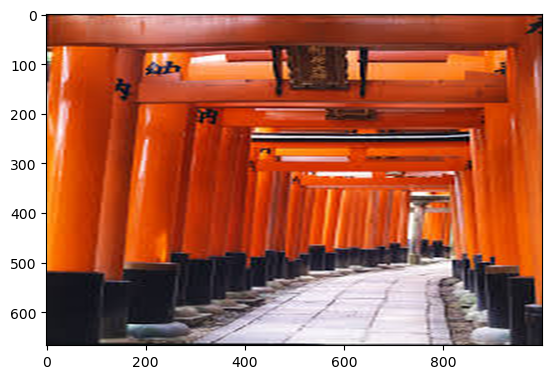

In [7]:
# Load the image
image_path = "../Pic/shrine.jpeg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Check if the image was loaded correctly
if img is None:
    print("Error: Could not load image. Please check the file path and try again.")
else:
    # Define the desired dimensions
    desired_width = 1000
    desired_height = 667

    # Resize the image using INTER_LANCZOS4 interpolation
    resized_img = cv2.resize(img, (desired_width, desired_height), interpolation=cv2.INTER_LANCZOS4)

    plt.imshow(resized_img)

    # Save the resized image as PNG
    output_path = "../Pic/Shirine_resized.png"
    cv2.imwrite(output_path, resized_img)
    print(f"Resized image saved as {output_path}")

In [13]:
image_path = "../Pic/Shirine_resized.png"
img = cv2.imread(image_path)



# Check if the image was loaded correctly
if img is None:
    print(f"Error: Could not load image at {image_path}. Please check the file path and try again.")
else:
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Split the LAB image into channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L-channel with the a and b channels
    limg = cv2.merge((cl, a, b))

    # Convert back to BGR color space
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Apply Gaussian blur for Unsharp Masking
    blurred = cv2.GaussianBlur(final_img, (9, 9), 10)

    # Apply Unsharp Masking
    sharpened_img = cv2.addWeighted(final_img, 1.5, blurred, -0.5, 0)

    # Display the original and enhanced images
    cv2.imshow('Original Image', img)
    cv2.imshow('Enhanced Image', sharpened_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the enhanced image as PNG
    output_path = "../Pic/Picture1.png"
    cv2.imwrite(output_path, sharpened_img)
    print(f"Enhanced image saved as {output_path}")

Enhanced image saved as ../Pic/Picture1.png
